In [1]:
import sys
sys.path.append("../")

In [2]:
from datetime import datetime
from functools import partial
from matplotlib.dates import DateFormatter
from ta import add_all_ta_features
from ta.utils import dropna
from utils.common_train_utils import *
from utils.draw_candle_image import *
from utils.evaluate_old_models import *
import json
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import shutil
import ta
import ta.momentum
import ta.trend
import tempfile
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
keras.config.enable_unsafe_deserialization()

In [3]:
dataset_folder = "../dataset/tcb_dataset_0_2_3_2018_2024_test_2024_2024_with_ema_macd_trend"
to_folder = "to_2024_11_22"
continue_learning_folder = f"{dataset_folder}/continue_learning/{to_folder}"
model_name = "model_5_bi2LSTM_ema_macd_trend"
index_of_image_input = 3
batch_size = 100

config = read_config(dataset_folder)
candle_type_and_directory_save: dict = config["candle_type_and_directory_save"]
previous_days = config["previous_days"]
next_days = config["next_days"]
days_result = config["days_result"]

In [4]:
function_transform_origin = get_origin_transform_function(
    os.path.join(
        os.path.abspath(f"{dataset_folder}/model_save/{model_name}"),
        "config_and_loss.json"
    )
)
path_of_model = f"{dataset_folder}/model_save/{model_name}/{model_name}.keras"
model = keras.models.load_model(os.path.abspath(path_of_model))


In [5]:
dataset_test = load_dataset_of_each_type_and_combine(continue_learning_folder, candle_type_and_directory_save)
total_data_test = len(dataset_test)


In [6]:
image_shape = get_image_shape(dataset_test, index_of_image_input)

In [7]:
dataset_test_1 = dataset_test
dataset_test_2 = dataset_test_1.batch(batch_size)
transform_function = partial(function_transform_origin, days_result)
dataset_test_3 = dataset_test_2.map(transform_function)

In [8]:
loss = model.evaluate(dataset_test_3)

d:\code\selenium\.venv\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['ema_9_input', 'macd_history_input', 'trend_type_input', 'image_input']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step - loss: 0.7973 - mae: 0.7583 - mse: 0.7973


In [9]:
loss

[0.7972632050514221, 0.758347749710083, 0.7972632050514221]

In [10]:
prediction_for_test = model.predict(dataset_test_3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


In [11]:
print(prediction_for_test)

[[[ 0.4322211   0.6163585 ]
  [ 0.26656806  0.41790816]
  [ 0.09792258  0.24315828]]

 [[-0.8224985  -0.3609754 ]
  [-0.4670896  -0.06829146]
  [-0.1769381   0.06965644]]

 [[-0.76351964 -0.3716558 ]
  [-0.38958377 -0.08114492]
  [-0.11830826  0.05640325]]

 [[-0.8224985  -0.3609754 ]
  [-0.4670896  -0.06829146]
  [-0.1769381   0.06965644]]

 [[-0.8224985  -0.3609754 ]
  [-0.4670896  -0.06829146]
  [-0.1769381   0.06965644]]

 [[ 0.7259922   1.2689743 ]
  [ 0.40338057  0.7703918 ]
  [ 0.09624881  0.40465158]]

 [[-0.3669492  -0.2568923 ]
  [-0.13149059 -0.01119941]
  [-0.01224053  0.07049119]]

 [[-0.82249844 -0.3609754 ]
  [-0.46708962 -0.06829147]
  [-0.1769381   0.06965646]]]


In [12]:
len(prediction_for_test)

8

In [13]:
all_dates = unwrap_dataset_at_index(dataset_test, 5, to_numpy=True, map_function=lambda date: str(datetime.fromisoformat(date.decode("utf-8")).date()))
trend_dataset_test_2 = unwrap_dataset_at_index(unwrap_dataset_at_index(dataset_test_2, 2, batch=True, to_numpy=True), 0)
_4_prices_of_all_days_dataset_test_2 = unwrap_dataset_at_index(dataset_test_2, 4, batch=True, to_numpy=True)
image_input_dataset_test_2 = unwrap_dataset_at_index(dataset_test_2, 3, batch=True, to_numpy=True)
real_percent_last_days_result_dataset_test_3 = unwrap_dataset_at_index(dataset_test_3, 1, batch=True, to_numpy=True) 

In [14]:
mapping_trend_type = {
    1: "GROUP_BULL",
    -1: "GROUP_BEAR",
    0: "GROUP_SIZEWAY",
}

In [15]:
def check_last_candle_is_up_or_down(df: pd.DataFrame, day_result):
    open = df.iloc[-day_result, 1]
    close = df.iloc[-day_result, 2]
    
    if open <= close:
        return "up"
    
    return "down"

In [16]:
def draw_prediction(
    x_dataset_test_1_i, 
    y_dataset_test_1_i, 
    date_i,
    predictions_i, 
    show_x_orginal_candle=False, 
    show_original_candle=False,
    show_prediction_candle=False,
    show_close_compare=False,
    show_open_compare=False,
    type_of_output=None,
    draw_beside=False,
    save_image=None,
    print_image=True,
    extend_real=False
    ):
    
    title_input = f"Biểu đồ giá đầu vào ngày {date_i}"
    title_real_candle = f"Biểu đồ giá cổ phiếu thực tế"
    title_predict_candle = f"Biểu đồ giá cổ phiếu dự đoán cho {days_result} ngày cuối của đồ thị"
    title_close = "Biểu đồ giá đóng cửa"
    title_open = "Biểu đồ giá mở cửa"
    
    label_real_close='Giá đóng cửa thật'
    label_predict_close=f'Giá đóng cửa dự đoán cho {days_result} ngày cuối'
    label_real_open='Giá mở cửa thật'
    label_predict_open=f'Giá mở cửa dự đoán cho {days_result} ngày cuối'
    
    
    if show_x_orginal_candle and not draw_beside:
        plt.imshow(x_dataset_test_1_i)
    
    df_real_data = pd.DataFrame(y_dataset_test_1_i, columns=["High", "Open", "Close", "Low"])
    
    mc = mpf.make_marketcolors(
    up='green', down='red', wick='inherit', edge='inherit', volume='inherit', )
    style = mpf.make_mpf_style(marketcolors=mc, figcolor="white")
    
    df_real_data['Date'] = pd.date_range(start='2023-01-01', periods=len(df_real_data), freq='D')
    df_real_data.set_index('Date', inplace=True)
    
    if show_original_candle and not draw_beside:
        fig, axlist = mpf.plot(
            df_real_data,
            type='candle',
            style=style,
            volume=False,  # Hiển thị khối lượng
            axisoff=False,  # Bỏ trục x và y
            returnfig=True,  # Trả về đối tượng Figure để tùy chỉnh
            figratio=(5, 5),  # Điều chỉnh tỷ lệ khung hình để thu hẹp khoảng cách
            figscale=1,  # Tăng kích thước biểu đồ để làm các nến gần nhau hơn
            panel_ratios=[6],
            title=title_real_candle,
        )
    
    df_predictions = df_real_data.copy()
    df_real_data_extend = df_real_data.copy()
    
    
    if type_of_output == "close":
        last_close_in_x_original_candle = df_predictions.iloc[-days_result-1, 2]
        df_predictions.iloc[-days_result:, 2] = (predictions_i.reshape(1,-1)[0]) * last_close_in_x_original_candle / 100 + last_close_in_x_original_candle
    elif type_of_output == "high_and_low":
        last_high_and_low_in_original_candle = y_dataset_test_1_i[-days_result-1, [0, 3]]
        df_predictions.iloc[-days_result:, [0, 3]] = (predictions_i.reshape(1,-1)[0]) * last_high_and_low_in_original_candle / 100 + last_high_and_low_in_original_candle
    elif type_of_output == "open_and_close":
        for day_result in range(days_result, 0, -1):
            is_real_up = check_last_candle_is_up_or_down(df_real_data, day_result) == "up"
            open_close_real_before = df_predictions.iloc[-day_result-1, [1, 2]]
            max_in_open_close_real_before = np.max(open_close_real_before)
            min_in_open_close_real_before = np.min(open_close_real_before)
            
            if days_result == 1:
                percent_predict = predictions_i
            else:
                percent_predict = predictions_i[-day_result]
            
            swaped = [max_in_open_close_real_before, min_in_open_close_real_before]
            result = (percent_predict * swaped) / 100 + swaped
            
            max_in_result = np.max(result)
            min_in_result = np.min(result)
            
            if is_real_up:
                df_predictions.iloc[-day_result, [1, 2]] = [min_in_result, max_in_result]
                if extend_real: df_real_data_extend.iloc[-day_result, [1, 2]] = df_real_data_extend.iloc[-day_result, [3, 0]]
            else:
                df_predictions.iloc[-day_result, [1, 2]] = [max_in_result, min_in_result]
                if extend_real: df_real_data_extend.iloc[-day_result, [1, 2]] = df_real_data_extend.iloc[-day_result, [0, 3]]
            df_predictions.iloc[-day_result, [0, 3]] = [max_in_result, min_in_result]
    elif type_of_output == "max_in_open_and_close":
        for day_result in range(days_result, 0, -1):
            is_real_up = check_last_candle_is_up_or_down(df_real_data, day_result) == "up"
            open_close_real_before = df_predictions.iloc[-day_result-1, [1, 2]]
            max_in_open_close_real_before = np.max(open_close_real_before)
            min_in_open_close_real_before = np.min(open_close_real_before)
            
            if days_result == 1:
                percent_predict = predictions_i
            else:
                percent_predict = predictions_i[-day_result]
            
            swaped = [max_in_open_close_real_before]
            result = (percent_predict * swaped) / 100 + swaped
            
            max_in_result = np.max(result)
            
            if is_real_up:
                df_predictions.iloc[-day_result:, [2]] = [max_in_result]
            else:
                df_predictions.iloc[-day_result:, [1]] = [max_in_result]

    else:
        last_close_in_x_original_candle = df_predictions.iloc[-days_result-1, 2]
        df_predictions.iloc[-days_result:] = (predictions_i.reshape(1,-1)[0]) * last_close_in_x_original_candle / 100 + last_close_in_x_original_candle
    
    if show_prediction_candle and not draw_beside:
        fig, axlist = mpf.plot(
            df_predictions,
            type='candle',
            style=style,
            volume=False,  # Hiển thị khối lượng
            axisoff=False,  # Bỏ trục x và y
            returnfig=True,  # Trả về đối tượng Figure để tùy chỉnh
            figratio=(5, 5),  # Điều chỉnh tỷ lệ khung hình để thu hẹp khoảng cách
            figscale=1,  # Tăng kích thước biểu đồ để làm các nến gần nhau hơn
            panel_ratios=[6],
            title=title_predict_candle,
        )
    
    if show_close_compare and not draw_beside:
        fig = plt.figure(figsize=(10, 6))
        plt.plot(df_real_data.index, df_real_data["Close"], color='blue', marker='o', linestyle='-', label=label_real_close)
        plt.plot(df_real_data.index, df_predictions["Close"], color='orange', marker='x', linestyle='--', label=label_predict_close)
        plt.title(title_close)
        plt.xlabel('Ngày')
        plt.ylabel('Giá Đóng cửa')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    if show_open_compare and not draw_beside:
        fig = plt.figure(figsize=(10, 6))
        plt.plot(df_real_data.index, df_real_data["Open"], color='blue', marker='o', linestyle='-', label=label_real_open)
        plt.plot(df_real_data.index, df_predictions["Open"], color='orange', marker='x', linestyle='--', label=label_predict_open)
        plt.title(title_open)
        plt.xlabel('Ngày')
        plt.ylabel('Giá Đóng cửa')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    
    # Tạo Figure và hai Subplots cạnh nhau
    if draw_beside:
        fig, ((ax0, ax00), (ax1, ax2), (ax3, ax4)) = plt.subplots(3, 2, figsize=(12, 12))
        
        
        ax0.set_title(title_input)
        
        ax1.set_title(title_real_candle)
        ax2.set_title(title_predict_candle)
        
        ax3.set_title(title_close)
        ax4.set_title(title_open)
        
        if extend_real:
            ax00.set_title(f"Biểu đồ khoảng giá cổ phiếu thực tế {days_result} ngày cuối của đồ thị")
            
            mpf.plot(
                df_real_data_extend,
                type='candle',
                style=style,
                volume=False,  # Hiển thị khối lượng
                axisoff=False,  # Bỏ trục x và y
                returnfig=True,  # Trả về đối tượng Figure để tùy chỉnh
                # figratio=(5, 5),  # Điều chỉnh tỷ lệ khung hình để thu hẹp khoảng cách
                # figscale=1,  # Tăng kích thước biểu đồ để làm các nến gần nhau hơn
                # panel_ratios=[6],
                # title="Biểu đồ giá cổ phiếu thực tế",
                ax=ax00
            )
            
        ax0.imshow(x_dataset_test_1_i)
        mpf.plot(
            df_real_data,
            type='candle',
            style=style,
            volume=False,  # Hiển thị khối lượng
            axisoff=False,  # Bỏ trục x và y
            returnfig=True,  # Trả về đối tượng Figure để tùy chỉnh
            # figratio=(5, 5),  # Điều chỉnh tỷ lệ khung hình để thu hẹp khoảng cách
            # figscale=1,  # Tăng kích thước biểu đồ để làm các nến gần nhau hơn
            # panel_ratios=[6],
            # title="Biểu đồ giá cổ phiếu thực tế",
            ax=ax1
        )
        mpf.plot(
            df_predictions,
            type='candle',
            style=style,
            volume=False,  # Hiển thị khối lượng
            axisoff=False,  # Bỏ trục x và y
            returnfig=True,  # Trả về đối tượng Figure để tùy chỉnh
            # figratio=(5, 5),  # Điều chỉnh tỷ lệ khung hình để thu hẹp khoảng cách
            # figscale=1,  # Tăng kích thước biểu đồ để làm các nến gần nhau hơn
            # panel_ratios=[6],
            # title="Biểu đồ giá cổ phiếu dự đoán",
            ax=ax2
        )
        
        ax3.plot(df_real_data.index, df_real_data["Close"], color='blue', marker='o', linestyle='-', label=label_real_close)
        ax3.plot(df_real_data.index, df_predictions["Close"], color='orange', marker='x', linestyle='--', label=label_predict_close)
        # ax3.title('Biểu đồ Giá Đóng cửa')
        # ax3.xlabel('Ngày')
        # ax3.ylabel('Giá Đóng cửa')
        ax3.legend()
        ax3.grid(True)
        
        ax4.plot(df_real_data.index, df_real_data["Open"], color='blue', marker='o', linestyle='-', label=label_real_open)
        ax4.plot(df_real_data.index, df_predictions["Open"], color='orange', marker='x', linestyle='--', label=label_predict_open)
        # ax4.title('Biểu đồ Giá Đóng cửa')
        # ax4.xlabel('Ngày')
        # ax4.ylabel('Giá Đóng cửa')
        ax4.legend()
        ax4.grid(True)
        
        date_format = DateFormatter('%b-%d')
        for ax in [ax1, ax2, ax3, ax4]:
            ax.xaxis.set_major_formatter(date_format)
        
        plt.tight_layout()
        if save_image is not None:
            plt.savefig(save_image)
        
        if print_image:
            plt.show()
        else:
            plt.close(fig)
        
        


real: [[-0.62111801 -1.04821803]
 [-1.25       -1.69491525]
 [-1.26582278 -0.64655172]]
prediction: [[-0.76351964 -0.3716558 ]
 [-0.38958377 -0.08114492]
 [-0.11830826  0.05640325]]


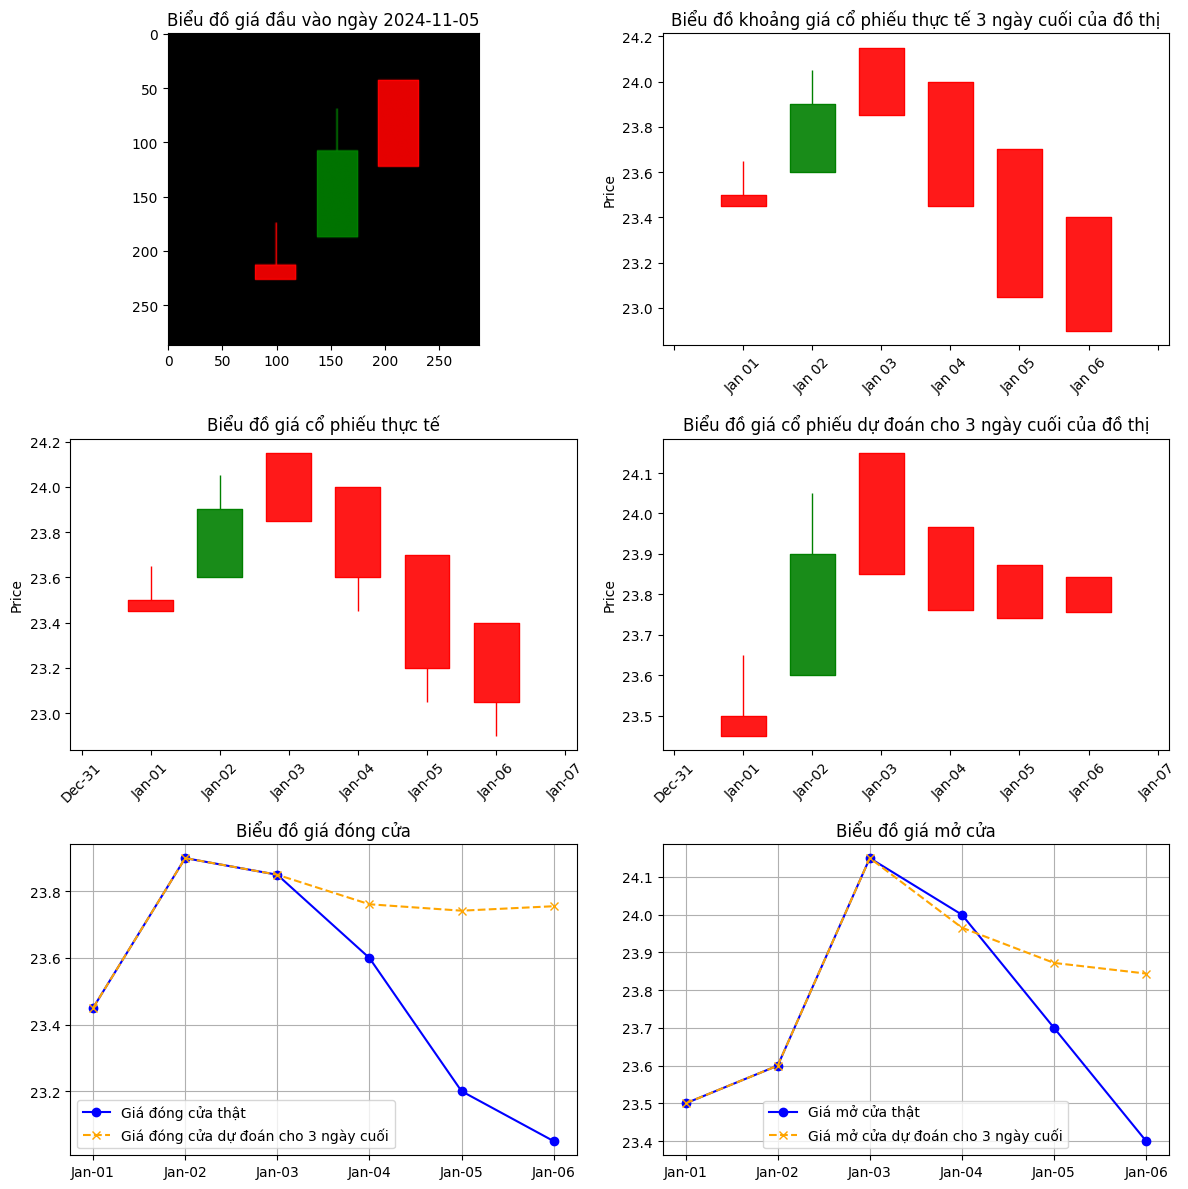

In [17]:
index = 2
print(f"real: {real_percent_last_days_result_dataset_test_3[index]}")
print(f"prediction: {prediction_for_test[index]}")
type_of_output = "open_and_close"
draw_prediction(
    image_input_dataset_test_2[index], 
    _4_prices_of_all_days_dataset_test_2[index], 
    all_dates[index],
    prediction_for_test[index], 
    show_x_orginal_candle=True,
    show_prediction_candle=True, 
    show_original_candle=True,
    show_close_compare=True,
    show_open_compare=True,
    type_of_output=type_of_output,
    draw_beside=True,
    print_image=True,
    extend_real=True)

In [21]:
# index = 0
is_print_all = input("Print all? (y/n): ").lower()[0] == "y"
group = input("Group to print? (bull/bear/sizeway/all) ").strip().lower()
is_extend_real = input("Extend real? (y/n): ").strip().lower()[0] == "y"
type_of_output = "open_and_close"
if is_print_all:
    if "bull" in group:
        group = "GROUP_BULL"
    elif "bear" in group:
        group = "GROUP_BEAR"
    elif "sizeway" in group:
        group = "GROUP_SIZEWAY"
    elif len(group) == 0 or "all" in group:
        group = None
    
    folder_name = f"{to_folder}/{model_name}"
    if group is not None:
        folder_name += f"_{group}"
    
    folder_save_image_predict = f"{dataset_folder}/output_prediction_image/continue_learning/{folder_name}"
    
    os.makedirs(folder_save_image_predict, exist_ok=False)
    
    date_printed = set()
    for index in range(len(_4_prices_of_all_days_dataset_test_2)):
        if index % 10 == 0:
            print(f"---------------- Save: {index}/{len(_4_prices_of_all_days_dataset_test_2)} images")
        print(f"real: {real_percent_last_days_result_dataset_test_3[index]}")
        print(f"prediction: {prediction_for_test[index]}")
        date = all_dates[index]
        if date in date_printed:
            continue
        else:
            date_printed.add(date)
        
        trend_type = mapping_trend_type[trend_dataset_test_2[index]]
        
        if group is not None:
            if trend_type != group:
                continue
        
        draw_prediction(
            image_input_dataset_test_2[index], 
            _4_prices_of_all_days_dataset_test_2[index], 
            date,
            prediction_for_test[index], 
            show_x_orginal_candle=True,
            show_prediction_candle=True, 
            show_original_candle=True,
            show_close_compare=True,
            show_open_compare=True,
            type_of_output=type_of_output,
            draw_beside=True,
            save_image=f"{folder_save_image_predict}/{date}_{trend_type}_predict.png",
            print_image=False,
            extend_real=is_extend_real)

---------------- Save: 0/8 images
real: [[ 1.0460251   1.05932203]
 [-0.62111801 -1.04821803]
 [-1.25       -1.69491525]]
prediction: [[0.4322211  0.6163585 ]
 [0.26656806 0.41790816]
 [0.09792258 0.24315828]]
real: [[-1.53508772 -0.22271715]
 [ 0.4454343   0.        ]
 [ 1.33037694 -0.44642857]]
prediction: [[-0.8224985  -0.3609754 ]
 [-0.4670896  -0.06829146]
 [-0.1769381   0.06965644]]
real: [[-0.62111801 -1.04821803]
 [-1.25       -1.69491525]
 [-1.26582278 -0.64655172]]
prediction: [[-0.76351964 -0.3716558 ]
 [-0.38958377 -0.08114492]
 [-0.11830826  0.05640325]]
real: [[-1.25       -1.69491525]
 [-1.26582278 -0.64655172]
 [-1.06837607 -0.21691974]]
prediction: [[-0.8224985  -0.3609754 ]
 [-0.4670896  -0.06829146]
 [-0.1769381   0.06965644]]
real: [[-1.26582278 -0.64655172]
 [-1.06837607 -0.21691974]
 [-0.64794816 -0.86956522]]
prediction: [[-0.8224985  -0.3609754 ]
 [-0.4670896  -0.06829146]
 [-0.1769381   0.06965644]]
real: [[0. 0.]
 [0. 0.]
 [0. 0.]]
prediction: [[0.7259922  1.2

In [19]:
folder_save_image_predict

'../dataset/tcb_dataset_0_2_3_2018_2024_test_2024_2024_with_ema_macd_trend/output_prediction_image/extend_real_continue_learning/to_2024_11_22'